In [1]:
import pandas as pd
import yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from modeling import ThreeLayerClassifier, update_config

In [2]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

In [3]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp["year"] = pbp["game_id"].apply(lambda x: int(x.split("_")[0]))
rushes = pbp.loc[(pbp.play_type=='run') & (~pbp.yards_gained.isna())].copy(
    deep=True
)


In [4]:
pbp[[x for x in pbp.columns if 'time' in x]]

,time,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,posteam_timeouts_remaining,defteam_timeouts_remaining,start_time,time_of_day,end_clock_time,drive_real_start_time,drive_time_of_possession,time_to_throw
0,15:00,3.0,3.0,NaN,None,NaN,NaN,"9/12/10, 16:15:48",None,None,None,None,NaN
1,15:00,3.0,3.0,0.0,None,3.0,3.0,"9/12/10, 16:15:48",2010-09-12T20:15:48Z,None,2010-09-12T20:15:48Z,4:10,NaN
2,14:55,3.0,3.0,0.0,None,3.0,3.0,"9/12/10, 16:15:48",2010-09-12T20:16:37Z,None,2010-09-12T20:15:48Z,4:10,NaN
3,14:24,3.0,3.0,0.0,None,3.0,3.0,"9/12/10, 16:15:48",2010-09-12T20:17:13Z,None,2010-09-12T20:15:48Z,4:10,NaN
4,13:43,3.0,3.0,0.0,None,3.0,3.0,"9/12/10, 16:15:48",2010-09-12T20:17:53Z,None,2010-09-12T20:15:48Z,4:10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
700837,00:28,2.0,2.0,0.0,None,2.0,2.0,"11/14/24, 20:15:56",2024-11-15T04:13:02Z,None,2024-11-15T04:01:25.167Z,4:10,NaN
700838,00:28,1.0,2.0,1.0,PHI,NaN,NaN,"11/14/24, 20:15:56",2024-11-15T04:16:01Z,None,None,None,NaN
700839,00:28,1.0,2.0,0.0,None,1.0,2.0,"11/14/24, 20:15:56",2024-11-15T04:16:53.223Z,2024-11-15T04:16:56.543Z,2024-11-15T04:16:53.223Z,0:28,NaN
700840,00:27,1.0,2.0,0.0,None,1.0,2.0,"11/14/24, 20:15:56",2024-11-15T04:17:35.493Z,2024-11-15T04:17:36.190Z,2024-11-15T04:16:53.223Z,0:28,NaN


In [5]:
pbp['play_time_elapsed'] = pbp['quarter_seconds_remaining'] - pbp.groupby(['game_id'])['quarter_seconds_remaining'].shift(-1)
#pbp['play_time_elapsed'] =  pbp['quarter_seconds_remaining'] - pbp['play_time_elapsed']
pbp[['quarter_seconds_remaining','play_time_elapsed','time', 'play_type', 'yards_gained', 'game_id']]

,quarter_seconds_remaining,play_time_elapsed,time,play_type,yards_gained,game_id
0,900.0,0.0,15:00,None,NaN,2010_01_ARI_STL
1,900.0,5.0,15:00,kickoff,0.0,2010_01_ARI_STL
2,895.0,31.0,14:55,pass,0.0,2010_01_ARI_STL
3,864.0,41.0,14:24,run,5.0,2010_01_ARI_STL
4,823.0,26.0,13:43,pass,18.0,2010_01_ARI_STL
...,...,...,...,...,...,...
700837,28.0,0.0,00:28,pass,2.0,2024_11_WAS_PHI
700838,28.0,0.0,00:28,no_play,0.0,2024_11_WAS_PHI
700839,28.0,1.0,00:28,kickoff,0.0,2024_11_WAS_PHI
700840,27.0,27.0,00:27,qb_kneel,-1.0,2024_11_WAS_PHI


In [6]:
pbp.groupby(['play_type'])['play_time_elapsed'].mean()

play_type
extra_point     0.038528
field_goal      4.357592
kickoff         2.591675
no_play         7.182316
pass           21.450256
punt            9.812216
qb_kneel       26.377756
qb_spike        2.021884
run            33.649349
Name: play_time_elapsed, dtype: float32

In [7]:
rusher_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[['season', 'team_name', 'week', 'game_type',  'gsis_id', 
       'position', 'depth_position', 'full_name', 'dense_depth',
 'carries_roll',
 'rushing_yards_roll',
 'rushing_tds_roll',
 'rushing_first_downs_roll',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']]
rushes = rushes.merge(
    rusher_stats,
    left_on=["posteam", "season", "week", "rusher_player_id"],
    right_on=["team_name", "season", "week", 'gsis_id'],
)
rushes

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,rushing_yards_roll,rushing_tds_roll,rushing_first_downs_roll,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_roll,fantasy_points_ppr_roll,yards_per_carry_roll
0,82.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000,4.153846
1,156.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000,4.153846
2,201.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000,4.153846
3,222.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000,4.153846
4,278.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,LA,home,ARI,...,81.000000,0.000000,6.000000,4.000000,8.000000,6.000000,0.000000,8.700000,12.700000,3.681818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204257,3751.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,PHI,home,WAS,...,119.070419,0.907189,5.165332,1.908009,2.533961,27.925872,0.164329,20.895065,22.803074,5.762302
204258,3973.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,28.898951,0.067896,1.533212,0.000000,0.000000,0.000000,0.000000,15.084039,15.084039,5.578199
204259,4000.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,13.359950,0.302242,1.131848,0.330419,0.486001,0.546436,0.000046,3.204369,3.534789,5.336112
204260,4052.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,13.359950,0.302242,1.131848,0.330419,0.486001,0.546436,0.000046,3.204369,3.534789,5.336112


In [8]:
rushes['play_end_ydline'] = (rushes['yardline_100'] - rushes['yards_gained'])
rushes = rushes.loc[~rushes.down.isna()].copy(deep=True)

In [9]:
game_context_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    "defteam_score",
    #"total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    #"wind",
    #"temp",
    'spread_line',
    'total_line'
]


full = ['desc','yards_gained', 'play_end_ydline'] + game_context_cols + rusher_stat_cols

In [10]:
rushes['play_end_ydline'] = (rushes['yardline_100'] - rushes['yards_gained'])
rushes = rushes.loc[~rushes.down.isna()][full].copy(deep=True)

In [11]:
rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll', 'yards_per_carry_roll']] = rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']].fillna(0)


In [12]:
rush_yards_cols = [ 'ydstogo',
 'yardline_100',
 'down',
 'goal_to_go',
 'posteam_score',
 'score_differential',
 'spread_line',
 'total_line',
 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

In [13]:
rushes['yards_shifted'] = rushes['yards_gained'].apply(lambda x: max(0, (x+5)))

In [14]:

small = rushes.copy()#loc[rushes.yardline_100 < 10]

X = torch.Tensor((small[rush_yards_cols].values))
y = torch.tensor(small['yards_shifted'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(rush_yards_cols)
# Update the model to match the input and output sizes



In [15]:

def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=512):
    # Define the model, loss function, and optimizer
    model = ThreeLayerClassifier(n_in, n_out, n_hidden=n_hidden)
    criterion = nn.CrossEntropyLoss()  # Suitable for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Split data into training and testing sets
    train_X, test_X = X[obs//5:], X[:obs//5]
    train_y, test_y = y[obs//5:], y[:obs//5]

    # Training loop
    epochs = 20
    batch_size = 512

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0))
        epoch_loss = 0

        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = train_X[indices], train_y[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: [batch_size, 100]
            loss = criterion(outputs, batch_y)  # batch_y must be [batch_size] with class indices
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_X):.4f}")

    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_preds = model(test_X)  # Shape: [num_samples, 100]
        test_loss = criterion(test_preds, test_y).item()
        accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return model

In [16]:
rush_yards_model = train_model(X,y, 12, 109) # 0.1394, 2.8083

Epoch 1/20, Loss: 0.0058
Epoch 2/20, Loss: 0.0055
Epoch 3/20, Loss: 0.0055
Epoch 4/20, Loss: 0.0055
Epoch 5/20, Loss: 0.0054
Epoch 6/20, Loss: 0.0054
Epoch 7/20, Loss: 0.0054
Epoch 8/20, Loss: 0.0054
Epoch 9/20, Loss: 0.0054
Epoch 10/20, Loss: 0.0054
Epoch 11/20, Loss: 0.0054
Epoch 12/20, Loss: 0.0054
Epoch 13/20, Loss: 0.0054
Epoch 14/20, Loss: 0.0054
Epoch 15/20, Loss: 0.0054
Epoch 16/20, Loss: 0.0054
Epoch 17/20, Loss: 0.0054
Epoch 18/20, Loss: 0.0054
Epoch 19/20, Loss: 0.0054
Epoch 20/20, Loss: 0.0054
Test Loss: 2.7578, Test Accuracy: 0.1443


In [17]:
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
    'rush_yard_cols':rush_yards_cols
}
feature_config

update_config(feature_config)

In [18]:
test = rushes.loc[rushes.yardline_100==1][rush_yards_cols+ ['yards_gained','yards_shifted']]
test

,ydstogo,yardline_100,down,goal_to_go,posteam_score,score_differential,spread_line,total_line,carries_roll,rushing_yards_roll,fantasy_points_ppr_roll,yards_per_carry_roll,yards_gained,yards_shifted
20,1.0,1.0,1.0,1,3.0,0.0,-3.0,39.5,13.000000,54.000000,15.400000,4.153846,1.0,6.0
127,1.0,1.0,1.0,1,0.0,-6.0,1.0,36.5,6.000000,-2.000000,4.200000,-0.333333,0.0,5.0
128,1.0,1.0,3.0,1,0.0,-6.0,1.0,36.5,6.000000,-2.000000,4.200000,-0.333333,1.0,6.0
198,1.0,1.0,1.0,1,24.0,8.0,5.5,40.5,12.000000,44.000000,8.500000,3.666667,-3.0,2.0
252,1.0,1.0,2.0,1,17.0,-21.0,5.0,44.5,15.000000,43.000000,10.400000,2.866667,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204133,1.0,1.0,3.0,1,7.0,4.0,-6.0,40.0,16.671225,64.090641,11.077406,4.553093,0.0,5.0
204134,1.0,1.0,1.0,1,7.0,4.0,-6.0,40.0,5.830440,19.166189,16.800818,3.645313,1.0,6.0
204182,1.0,1.0,2.0,1,6.0,-4.0,6.0,49.0,14.995538,53.712783,15.299467,4.034152,1.0,6.0
204205,1.0,1.0,1.0,1,0.0,0.0,4.5,49.5,14.966429,62.990138,13.214529,4.408641,1.0,6.0


In [20]:
rush_yards_model(torch.tensor(test[rush_yards_cols].values.tolist())).argmax(dim=1)

tensor([6, 5, 5,  ..., 6, 6, 6])

In [21]:
colormap = cm.gnuplot
plt.figure(figsize=(14, 8))
num_yardlines = 3
for yardline in range(1,num_yardlines):
    color = colormap(yardline / num_yardlines) 
    down=1
    test = small.loc[small.yardline_100==yardline]
    xx = torch.Tensor(test[rush_yards_cols].sample(1).values)
    print(xx.shape)
    with torch.no_grad():
        xy = model(xx)
        xy = (100 * F.softmax(xy,dim=1))[0]
        print(xy.shape)
        x_range = range(0,25)
    plt.axvline(yardline + 5, color=color, linestyle='-.')
    plt.plot(x_range, xy[0:25], label=yardline, color=color)

plt.legend()

torch.Size([1, 12])


NameError: name 'model' is not defined

<Figure size 1400x800 with 0 Axes>

(array([  956.,  1195.,  1868.,     0.,  2931., 12142.,     0., 39395.,
        41255.,   258.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

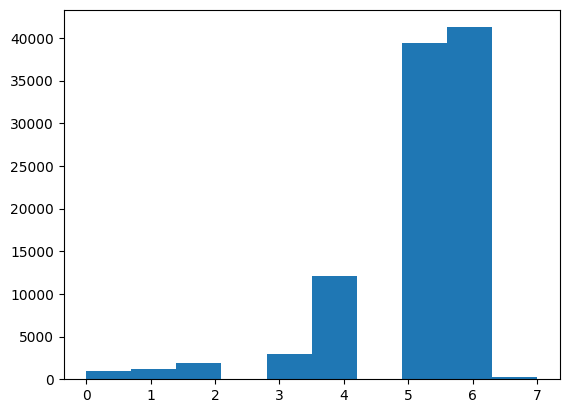

In [23]:
res = rush_yards_model(xx)
res = F.softmax(res,dim=1)[0]
samples = torch.clamp( torch.multinomial(res,100000,replacement=True), max=7)
plt.hist(samples)

<Axes: >

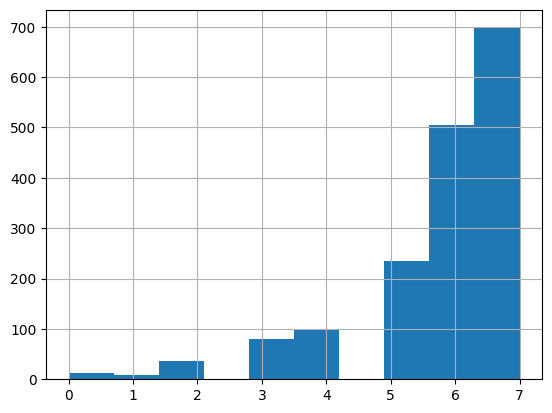

In [24]:
rushes.loc[rushes.yardline_100==2]['yards_shifted'].hist()

In [25]:
[x for x in pbp.columns if 'ard' in x]

['yardline_100',
 'yards_gained',
 'air_yards',
 'yards_after_catch',
 'passing_yards',
 'receiving_yards',
 'rushing_yards',
 'lateral_receiving_yards',
 'lateral_rushing_yards',
 'fumble_recovery_1_yards',
 'fumble_recovery_2_yards',
 'return_yards',
 'penalty_yards',
 'end_yard_line',
 'drive_yards_penalized',
 'drive_start_yard_line',
 'drive_end_yard_line',
 'xyac_mean_yardage',
 'xyac_median_yardage',
 'ngs_air_yards']

In [26]:
pbp.loc[
    (pbp['pass']==1) & 
    (pbp.pass_attempt==1)
    & (pbp.play_type=='run')
    ]['desc']

Series([], Name: desc, dtype: object)

In [27]:
passes = pbp.loc[
        (pbp['pass']==1) & 
    (pbp.pass_attempt==1) & 
    (pbp.air_yards >= -20)
    & (pbp.play_type=='pass')
].copy(deep=True).dropna(axis=1,how='all')

In [28]:
receiver_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[[
    "season",
    "team_name",
    "week",
    "game_type",
    "gsis_id",
    "position",
    "depth_position",
    "full_name",
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
]]

In [29]:
passes = passes.merge(
    receiver_stats,
    left_on=["posteam", "season", "week", "receiver_player_id"],
    right_on=["team_name", "season", "week", "gsis_id"],
)
passes


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,receiving_air_yards_roll,receiving_yards_after_catch_roll,receiving_first_downs_roll,target_share_roll,air_yards_share_roll,fantasy_points_ppr_roll
0,58.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,1.000000
1,103.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,3.000000,15.000000,43.000000,1.000000,226.000000,11.000000,2.000000,0.375000,0.548544,13.300000
2,132.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,4.000000,4.000000,40.000000,0.000000,3.000000,37.000000,2.000000,0.100000,0.007282,15.400000
3,177.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,7.000000,7.000000,132.000000,0.000000,72.000000,60.000000,6.000000,0.175000,0.174757,20.200001
4,254.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,LA,home,ARI,...,10.000000,16.000000,119.000000,0.000000,162.000000,29.000000,5.000000,0.290909,0.429708,21.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265196,4128.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,2.572266,5.114584,32.631505,0.111683,59.520894,5.596245,1.353489,0.179896,0.324878,6.505511
265197,4158.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,0.330419,0.486001,0.546436,0.000046,-0.090987,0.340379,0.005887,0.018448,-0.000367,3.534789
265198,4183.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,1.569767,2.629043,18.062809,0.000365,17.071265,8.859966,0.829470,0.093514,0.105338,3.378239
265199,4217.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,4.342260,6.275367,38.638658,0.365887,38.485479,10.690203,2.571123,0.203732,0.189725,11.032262


In [30]:
passes = passes.loc[~passes.receptions_roll.isna()].copy()
#51456 

In [31]:
air_yards_cols = [
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
] + game_context_cols

In [32]:
passes['target_share_roll'].isna().sum()

0

In [33]:
passes['air_yards_20'] = passes['air_yards'] + 20
data = passes[air_yards_cols + ['air_yards_20']].copy()
data = data.dropna()
X = torch.Tensor((data[air_yards_cols].values))
y = torch.tensor(data['air_yards_20'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(air_yards_cols)
y.shape

torch.Size([263632])

In [34]:
air_yards_model = train_model(X, y, num_feats, 119)

Epoch 1/20, Loss: 0.0085
Epoch 2/20, Loss: 0.0066
Epoch 3/20, Loss: 0.0066
Epoch 4/20, Loss: 0.0065
Epoch 5/20, Loss: 0.0065
Epoch 6/20, Loss: 0.0065
Epoch 7/20, Loss: 0.0065
Epoch 8/20, Loss: 0.0065
Epoch 9/20, Loss: 0.0065
Epoch 10/20, Loss: 0.0064
Epoch 11/20, Loss: 0.0064
Epoch 12/20, Loss: 0.0064
Epoch 13/20, Loss: 0.0064
Epoch 14/20, Loss: 0.0064
Epoch 15/20, Loss: 0.0064
Epoch 16/20, Loss: 0.0064
Epoch 17/20, Loss: 0.0064
Epoch 18/20, Loss: 0.0064
Epoch 19/20, Loss: 0.0064
Epoch 20/20, Loss: 0.0064
Test Loss: 3.2459, Test Accuracy: 0.0958


In [35]:
model_path = "models/air_yards.pt"
torch.save(air_yards_model.state_dict(), model_path)


feature_config = {
    'air_yards_cols':air_yards_cols,
    'air_yards_model_path': 'models/air_yards.pt',
    'run_yards_model_path': "models/run_yards_gained.pt"
}
feature_config

update_config(feature_config)

<Axes: >

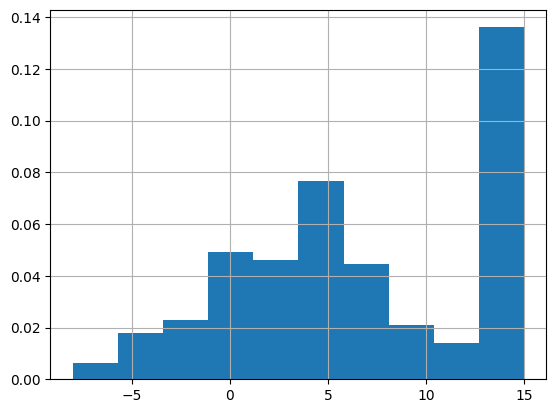

In [36]:
n = 15
ydl = data.loc[data.yardline_100==n]
(ydl['air_yards_20'] - 20).hist(density=True)

(array([2.35294118e-06, 2.17647059e-05, 2.78823529e-04, 3.29000000e-03,
        1.77905882e-02, 4.05411765e-02, 5.38132353e-02, 6.93767647e-02,
        3.49741176e-02, 7.40288235e-02]),
 array([-19. , -15.6, -12.2,  -8.8,  -5.4,  -2. ,   1.4,   4.8,   8.2,
         11.6,  15. ]),
 <BarContainer object of 10 artists>)

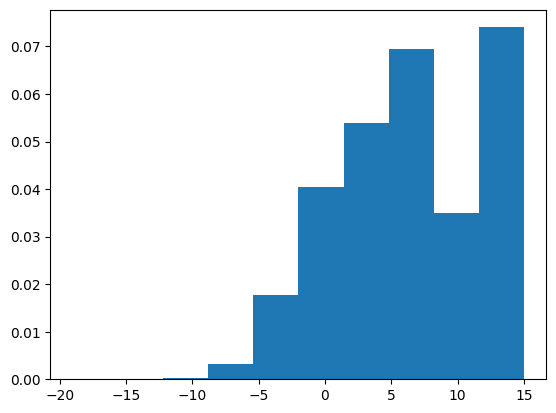

In [37]:
test_x = torch.Tensor(ydl.sample(100)[air_yards_cols].values)
res = air_yards_model(test_x)
res = F.softmax(res,dim=1)
samples = torch.clamp( torch.multinomial(res,10000,replacement=True), max=(n +20)).reshape(-1) - 20
plt.hist(samples,density=True)

In [38]:
passes[['yardline_100','yards_gained','air_yards','yards_after_catch', 'complete_pass']]

,yardline_100,yards_gained,air_yards,yards_after_catch,complete_pass
0,78.0,0.0,0.0,0.0,1.0
1,73.0,18.0,7.0,11.0,1.0
2,55.0,17.0,0.0,17.0,1.0
3,36.0,12.0,12.0,0.0,1.0
4,32.0,13.0,13.0,0.0,1.0
...,...,...,...,...,...
265196,20.0,4.0,-3.0,7.0,1.0
265197,16.0,1.0,1.0,0.0,1.0
265198,15.0,10.0,10.0,0.0,1.0
265199,5.0,0.0,3.0,NaN,0.0


In [39]:
completions = passes.loc[passes.complete_pass==1].copy()
completions['yac_25'] = completions['yards_after_catch'] + 25

In [40]:
yac_cols = air_yards_cols + ['air_yards']
data = completions[yac_cols + ['yac_25']].copy()
data = data.dropna()
X = torch.Tensor((data[yac_cols].values))
y = torch.tensor(data['yac_25'].astype(int).values, dtype=torch.long)
obs = len(X)
air_yards_input = len(yac_cols)
X.shape

torch.Size([170443, 24])

In [41]:
           
yac_model = train_model(X, y, 24, 125)

Epoch 1/20, Loss: 0.0063
Epoch 2/20, Loss: 0.0053
Epoch 3/20, Loss: 0.0053
Epoch 4/20, Loss: 0.0052
Epoch 5/20, Loss: 0.0052
Epoch 6/20, Loss: 0.0052
Epoch 7/20, Loss: 0.0051
Epoch 8/20, Loss: 0.0051
Epoch 9/20, Loss: 0.0051
Epoch 10/20, Loss: 0.0051
Epoch 11/20, Loss: 0.0051
Epoch 12/20, Loss: 0.0051
Epoch 13/20, Loss: 0.0050
Epoch 14/20, Loss: 0.0050
Epoch 15/20, Loss: 0.0050
Epoch 16/20, Loss: 0.0050
Epoch 17/20, Loss: 0.0050
Epoch 18/20, Loss: 0.0050
Epoch 19/20, Loss: 0.0050
Epoch 20/20, Loss: 0.0050
Test Loss: 2.5497, Test Accuracy: 0.2484


(array([3.07692308e-06, 3.84615385e-07, 2.50000000e-05, 3.38461538e-05,
        5.38461538e-05, 1.06076923e-03, 2.48595385e-01, 4.79746154e-02,
        4.38884615e-02, 4.29800000e-02]),
 array([-17. , -14.4, -11.8,  -9.2,  -6.6,  -4. ,  -1.4,   1.2,   3.8,
          6.4,   9. ]),
 <BarContainer object of 10 artists>)

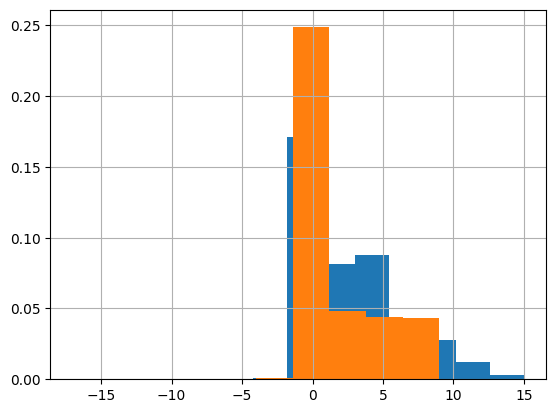

In [42]:
n = 9
ydl = data.loc[data.yardline_100==n]
(ydl['yac_25'] - 25).hist(density=True)
test_x = torch.Tensor(ydl.sample(100)[yac_cols].values)
res = yac_model(test_x)
res = F.softmax(res,dim=1)
samples = torch.clamp(torch.multinomial(res,10000,replacement=True).reshape(-1), max= (n+25)) - 25
plt.hist(samples,density=True)

In [43]:
model_path = "models/yac.pt"
torch.save(yac_model.state_dict(), model_path)


feature_config = {
    'yac_cols':yac_cols,
    'yac_path': 'models/yac.pt',
    'run_yards_model_path': "models/run_yards_gained.pt"
}
feature_config

update_config(feature_config)

In [44]:
pbp['desc'].sample(15)

684755    (14:17) (Shotgun) 7-J.Brissett pass short left...
338488    (9:27) (Shotgun) 11-A.Smith pass short left to...
444318    3-D.Hopkins kicks 65 yards from WAS 35 to end ...
37490     (14:14) 3-S.Hauschka 46 yard field goal is GOO...
55809     9-R.Gould kicks 62 yards from CHI 35 to CAR 3....
319463    (6:59) (Field Goal formation) 3-A.Franks 46 ya...
668669    4-J.Moody kicks 62 yards from SF 35 to LA 3, f...
627022    (13:45) 21-J.Williams right guard to CAR 45 fo...
119137    (3:06) (No Huddle) 12-A.Luck pass short left t...
387430    (10:57) (No Huddle) 21-E.Elliott left tackle t...
158291    6-S.Suisham kicks 65 yards from PIT 35 to end ...
481744    6-C.Jones kicks 59 yards from DAL 20 to SEA 21...
520452    7-K.Fairbairn kicks 65 yards from HOU 35 to en...
251150    (12:00) (Shotgun) 14-A.Dalton pass deep middle...
76059     (13:05) 15-G.Little left end to CIN 46 for 13 ...
Name: desc, dtype: object

In [45]:
pbp.iloc[177294].dropna().to_dict()

{'play_id': 2348.0,
 'game_id': '2013_14_BUF_TB',
 'old_game_id': '2013120807',
 'home_team': 'TB',
 'away_team': 'BUF',
 'season_type': 'REG',
 'week': 14,
 'posteam': 'BUF',
 'posteam_type': 'away',
 'defteam': 'TB',
 'side_of_field': 'BUF',
 'yardline_100': 74.0,
 'game_date': '2013-12-08',
 'quarter_seconds_remaining': 843.0,
 'half_seconds_remaining': 1743.0,
 'game_seconds_remaining': 1743.0,
 'game_half': 'Half2',
 'quarter_end': 0.0,
 'drive': 18.0,
 'sp': 0.0,
 'qtr': 3.0,
 'down': 2.0,
 'goal_to_go': 0,
 'time': '14:03',
 'yrdln': 'BUF 26',
 'ydstogo': 9.0,
 'ydsnet': 52.0,
 'desc': '(14:03) (No Huddle, Shotgun) 3-E.Manuel scrambles up the middle to BUF 36 for 10 yards (54-L.David).',
 'play_type': 'run',
 'yards_gained': 10.0,
 'shotgun': 1.0,
 'no_huddle': 1.0,
 'qb_dropback': 1.0,
 'qb_kneel': 0.0,
 'qb_spike': 0.0,
 'qb_scramble': 1.0,
 'run_location': 'middle',
 'home_timeouts_remaining': 3.0,
 'away_timeouts_remaining': 3.0,
 'timeout': 0.0,
 'posteam_timeouts_remaining

In [46]:
pbp.iloc[177294]['pass_attempt']

0.0

In [47]:
list(pbp.loc[pbp.play_type=='run']['desc'].sample(15))

['(:07) (Shotgun) 31-E.Demercado up the middle to DET 24 for 6 yards (97-A.Hutchinson).',
 '(11:46) (Shotgun) 25-T.Riddick left end to DET 44 for -3 yards (58-K.Alexander).',
 '(14:23) 32-J.Patterson left tackle to WAS 39 for 3 yards (94-J.Sweat).',
 '(6:52) (Shotgun) 30-J.Wilson left end to SF 30 for 5 yards (91-G.Gaines, 33-N.Scott).',
 '(12:22) 34-R.Mendenhall right tackle to PIT 49 for -2 yards (24-S.Brown).',
 '(13:49) 12-V.Jones right end pushed ob at CHI 46 for 13 yards (44-M.Rodriguez).',
 '(13:51) (No Huddle) 33-A.Jones right end to GB 45 for no gain (55-B.Graham; 91-F.Cox).',
 '(3:23) (Shotgun) 30-T.Gurley left guard to LA 29 for 3 yards (36-D.Swearinger).',
 '(2:00) 33-C.Michael up the middle to JAX 33 for 9 yards (50-R.Allen; 26-J.Evans).',
 '(14:27) 32-J.Rodgers right tackle to TB 36 for 6 yards (21-L.Collins).',
 '(3:51) (Shotgun) 14-Z.Pascal right end pushed ob at JAX 34 for 4 yards (40-B.Watson).',
 '(1:33) 26-T.Coleman right guard to ATL 4 for 2 yards (22-H.Smith). Pen

In [48]:
list(pbp.loc[(pbp.rusher_player_name=='J.Hurts') & (pbp.down==4) & (pbp.ydstogo == 1)]['desc'])

['(8:16) (Shotgun) 2-J.Hurts up the middle to NO 42 for 3 yards (43-M.Williams).',
 '(3:11) 2-J.Hurts up the middle to NO 40 for no gain (58-K.Alexander; 43-M.Williams).',
 '(10:26) 1-J.Hurts up the middle to PHI 35 for 1 yard (77-Q.Jefferson; 90-J.Hankins).',
 '(5:36) (No Huddle) 1-J.Hurts left guard to WAS 39 for 3 yards (95-C.Toohill).',
 '(13:00) (Shotgun) 1-J.Hurts scrambles right end for 1 yard, TOUCHDOWN.',
 '(1:06) 1-J.Hurts up the middle to DET 39 for 1 yard (55-D.Barnes).',
 '(12:51) (No Huddle) 1-J.Hurts up the middle to PHI 33 for 3 yards (95-R.Robertson-Harris; 41-J.Allen).',
 '(1:10) 1-J.Hurts up the middle to JAX 10 for 2 yards (41-J.Allen).',
 '(8:40) (No Huddle) 1-J.Hurts up the middle to ARI 1 for 2 yards (25-Z.Collins; 94-Z.Allen).',
 '(1:36) 1-J.Hurts up the middle to PHI 35 for 1 yard (58-C.Kirksey).',
 '(5:06) 1-J.Hurts FUMBLES (Aborted) at PHI 37, recovered by PHI-26-M.Sanders at PHI 37. 26-M.Sanders to PHI 37 for no gain (29-R.Douglas).',
 '(:54) 1-J.Hurts right